In [1]:
import sys
sys.path.append("..")
from bast.alternative import scattering_structured_layer, Lattice,redheffer_product,incident,scattering_reflection,scattering_transmission, scattering_uniform_layer, convolution_matrix
import numpy as np
import matplotlib.pyplot as plt
from bast.tools import c
from skimage.transform import resize

In [2]:
M = 1024
N = 512
eps = np.ones((M,M)) 
x = np.linspace(-0.5, 0.5, M, endpoint=True)
y = np.linspace(-0.5, 0.5, M, endpoint=True)
X, Y = np.meshgrid(x, y)
eps[X**2+Y**2<= 0.2**2] = 4
#eps = resize(eps, (N,N), anti_aliasing=True)

1.4285714285714286


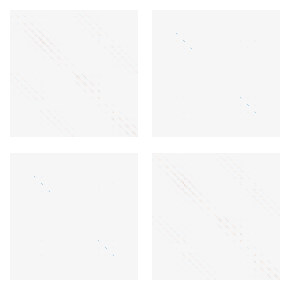

In [15]:
from cmath import sqrt as csqrt
pw = (9,9)

a = 1 # um
freq = 0.7 * c / a 
wl = c / freq
print(wl)
omega = 2 * np.pi * freq
k0 = 2*np.pi / wl
kpinc = (k0 *  np.sin(np.deg2rad(0)),0)
l = Lattice(pw, a, wl, kpinc)
d = 0.3 * a
Sdevice, device_ev, WI, VI = scattering_structured_layer(l, eps, d, return_eigenspace=True)
Sref, Wref, Vref = scattering_reflection(l.Kx, l.Ky, l.W0, l.V0)
Strans, Wtrans, Vtrans,ev_trans = scattering_transmission(l.Kx, l.Ky, l.W0, l.V0)
#for i in range(power):
#    S1 = redheffer_product(S1.copy(),S1.copy())
S1 = redheffer_product(Sref, Sdevice.copy())
S1 = redheffer_product(S1.copy(), Strans)
fig, axs = plt.subplots(2,2, figsize=(3,3))
axs[0,0].matshow(S1[0,0].real, vmin=-1, vmax=1, cmap="RdBu")
axs[1,0].matshow(S1[1,0].real, vmin=-1, vmax=1, cmap="RdBu")
axs[0,1].matshow(S1[0,1].real, vmin=-1, vmax=1, cmap="RdBu")
axs[1,1].matshow(S1[1,1].real, vmin=-1, vmax=1, cmap="RdBu")
for ax in axs.flat:
    ax.axis("off")
plt.tight_layout()

[0.70710678+0.j 0.70710678+0.j]


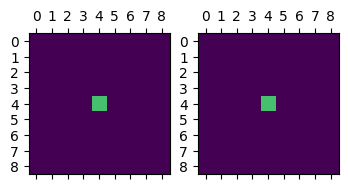

In [16]:
epsi = 1.0
kzi = np.conj(csqrt(k0**2*epsi-kpinc[0]**2-kpinc[1]**2))
# 01TE 10TM
incident_fields = incident(l.pw, 0.707, 0.707, kp=(l.kp[0], l.kp[1], kzi))
print(incident_fields[incident_fields!=0])
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(4,2))
ax1.matshow(np.split(incident_fields,2)[0].real.reshape(pw), vmin=0, vmax=1)
ax2.matshow(np.split(incident_fields,2)[1].real.reshape(pw), vmin=0, vmax=1)

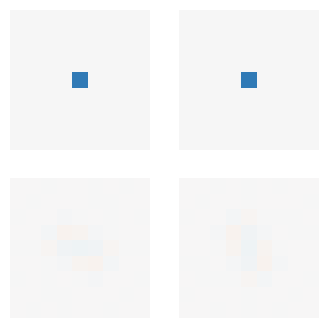

In [17]:
from numpy.linalg import inv
c1p = inv(Wref) @ incident_fields
c2p = S1[1,0] @ c1p
c1m = S1[0,0] @ c1p
fig, axs = plt.subplots(2,2, figsize=(4,4))
axs[0,0].matshow(np.split(c1p,2)[0].real.reshape(pw), vmin=-1, vmax=1, cmap="RdBu")
axs[0,1].matshow(np.split(c1p,2)[1].real.reshape(pw), vmin=-1, vmax=1, cmap="RdBu")
axs[1,0].matshow(np.split(c2p,2)[0].real.reshape(pw), vmin=-1, vmax=1, cmap="RdBu")
axs[1,1].matshow(np.split(c2p,2)[1].real.reshape(pw), vmin=-1, vmax=1, cmap="RdBu")
_=[ax.axis("off") for ax in axs.flat]

In [18]:
from itertools import product
from bast.tools import mu0
resolution = (101, 101)
mulx = 1
muly = 1
vx = np.linspace(-mulx*a, muly*a, resolution[0])
vy = np.linspace(-mulx*a, muly*a, resolution[1])
gx = k0 * np.diag(l.Kx)
gy = k0 * np.diag(l.Ky)
extent = [-mulx*a, mulx*a, -muly*a, muly*a]
extent = [ e * 1e6 for e in extent]

In [39]:
IC = convolution_matrix(1/eps, pw)
zrs = np.linspace(0,1,64)
Srd = redheffer_product(Sref, Sdevice)

from bast.fields import translate_mode_amplitudes, fourier2direct2, fourier_fields_from_mode_amplitudes
eigenvalues = np.diag(device_ev).copy()

vox_fields = []
for il, zr in enumerate(zrs):
    z = zr * d
    cdplus, cdminus = translate_mode_amplitudes(Srd, c1p, c1m)
    sx, sy, ux, uy = fourier_fields_from_mode_amplitudes((WI, VI, eigenvalues), (Wref, Vref, None), (cdplus, cdminus), k0*z)
    
    uz = -1j * ( gx * sy -  gy * sx)
    sz =  -1j * IC @  (gx * uy - gy * ux)
    ex, ey, ez, hx, hy, hz = [ fourier2direct2(s.reshape(pw), l.kx, l.ky, a, kp=kpinc) for s in [sx, sy, sz, ux, uy, uz]]
    E = ex, ey, ez
    H = hx, hy, hz
    vox_fields.append(H)
vox_fields = np.asarray(vox_fields)
vox_fields = np.swapaxes(vox_fields, 1, 3)

(128, 127, 127, 3)


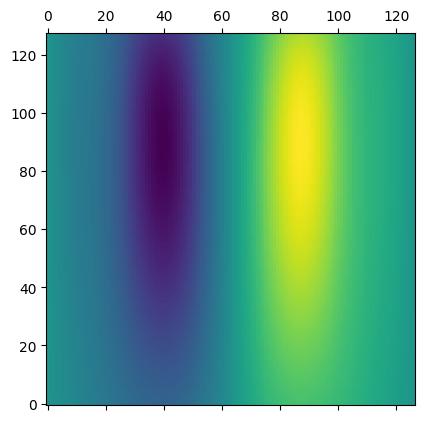

In [40]:
print(vox_fields.shape)
plt.matshow(vox_fields.real[:, 64,:, 2], origin="lower")